In [10]:
from tqdm.notebook import tqdm

import numpy as np

import datetime
from pathlib import Path

import intake

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score

import lightgbm

import plotly.graph_objects as go

In [2]:
catalog = intake.open_catalog(Path('../catalog.yml'))
source = getattr(catalog, 'treesat')
gdf = source.read()[source.metadata['usecols']]
gdf.crs = 25832
gdf = gdf.to_crs(epsg=4326)

In [3]:
selected_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12', 'TCI_R', 'TCI_G', 'TCI_B']
print(selected_bands)

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'TCI_R', 'TCI_G', 'TCI_B']


In [4]:
class LightModelCreator:  
    def train(self, X_train, y_train):
        params = dict(
            verbose=0, 
            # device_type='gpu'
        )
        lgb = lightgbm.LGBMClassifier(**params)

        stacked_model = OneVsRestClassifier(lgb)
        stacked_model.fit(X_train, y_train)
        return stacked_model
    
    def predict(self, X, y, random_state=42):
        X = X.reshape(len(y), -1)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=random_state)
        
        stacked_model = self.train(X_train, y_train)
        y_pred = stacked_model.predict(X_test)
        return accuracy_score(y_test, y_pred)
    
    def run_and_eval(self, labels, filepaths):
        scores = []
        for filepath in tqdm(filepaths):
            with open(filepath, 'rb') as f:
                data = np.load(f)
                data = data.view((float, len(data.dtype.names)))
            
            # scores[filepath.stem] = self.predict(data, labels)
            scores.append(self.predict(data, labels))
        return scores

In [5]:
target = source.metadata['categories']['multi']
gdf[target] = gdf[target].astype('category')

In [6]:
filepaths = sorted(list(Path('data_mean').glob('treesat_2019*.npy')))
mean_scores = LightModelCreator().run_and_eval(
    gdf[target].cat.codes, filepaths)

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
filepaths = sorted(list(Path('data_median').glob('treesat_2019*.npy')))
median_scores = LightModelCreator().run_and_eval(
    gdf[target].cat.codes, filepaths)

  0%|          | 0/12 [00:00<?, ?it/s]

In [12]:
months = list(range(1, 13))

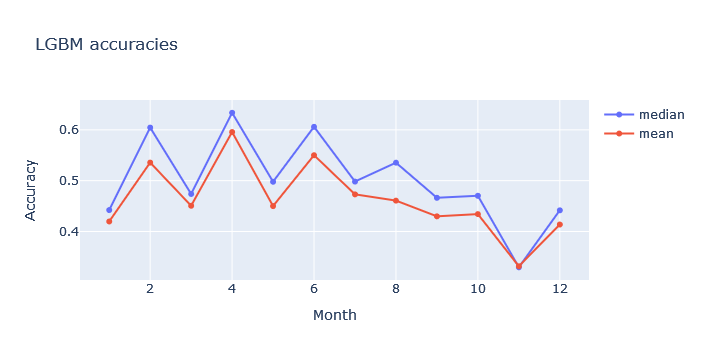

In [13]:
go.Figure(
    data = [
        go.Scatter(x=months, y=median_scores, name='median'),
        go.Scatter(x=months, y=mean_scores, name='mean'),
    ],
    layout = {"xaxis": {"title": "Month"}, "yaxis": {"title": "Accuracy"}, "title": "LGBM accuracies"}
)